In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn import linear_model
from catboost import CatBoostRegressor
import lightgbm as lgb
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import VotingRegressor,GradientBoostingRegressor

from lightgbm import LGBMRegressor
from sklearn.model_selection import TimeSeriesSplit


#!pip install yfinance

# Problem Tanımı ve Çözüm

İyzico ile ödeme gerçekleştiren işyerlerinde aylık olarak gerçekleşebilecek işlem adetinin tahminlenmesi.

Modellemeye lag özellikleri ve diğer kategorik özellikleri kullanarak tüm işyerleri için tek bir model oluşturarak başladım. Fakat bu yöntem çok iyi sonuçlar vermedi nedeni ise işyerleri arasındaki verilerin trendlerinin çok farklı olmasıydı. Bu aşamadan sonra farklı bir çözüm yolu bulmak istedim. Üyeye ait işlem adetini tahmin etmede son ayın değerleri oluşturduğum modele göre çok daha iyi sonuçlar veriyordu.Bu yüzden çözümümde  üyeliğini iptal etmiş veya  tahminelenebilirliği son ayın değerine göre  düşük olan üyeler için son ayın değerini tahmin olarak seçerken, modeller ile iyi tahminlenebilen üyelerin hepsi için ayrı model oluşturarak tahmin değeri oluşturdum. Kısaca çözümde anahtar kısım verisinde fazla gürültü bulunmayan ve trende sahip üyeleri seçebilmekti.

In [2]:
traindf = pd.read_csv("/kaggle/input/iyzico-datathon/train.csv")
submission_df = pd.read_csv("/kaggle/input/iyzico-datathon/sample_submission.csv")
orj = traindf.copy()


In [3]:

def prepare_train_test_data(train_data, year_filter=2023, months_filter=[ 7, 8, 9], date_cutoff="2023-07-01"):
    
    train = train_data.copy()
    cat_var = train.drop(["net_payment_count", "month_id", "merchant_id"], axis=1).columns

     
    # Extract year and month from the index
    train["date"] = pd.to_datetime(train['month_id'], format='%Y%m')
    train = train.set_index("date")
    train["year"] = train.index.year
    train["month"] = train.index.month
    train['month_id'] = pd.to_datetime(train['month_id'], format='%Y%m')
    
    

     # Select and reorder columns
    train.rename(columns={'merchant_id': 'id', 'net_payment_count': 'target'}, inplace=True)
    train = train[["id", "month_id", "target", "year", "month","merchant_source_name","settlement_period","working_type",
                   "mcc_id","merchant_segment"]]
    train = train.sort_values(by=["year", "month"])

    # Filter test data based on the specified conditions
    test = train[(train.year == year_filter) & (train.month.isin(months_filter))]
    train = train[train.index < date_cutoff]

    

    # Filter test data to include only ids present in train data
    idx = train.id.unique()
    test = test[test.id.isin(idx)]

    return train, test





""" yarışmada bizden, verisetindeki her bir kullanıcı için tahmini işlem adetini 
tahmin etmemiz istendi.Bu kullanıcların bir çoğu üyeliğini iptal etmiş veya aktif olarak 
işlem gerçekleştirmeyen üyelerdir ve aylık işlem adeti 0 a yakın değerlerdir.fakat bize verilen
train verisetinde aylık aktif kullanıcılar yer alıyordu o yüzden sadece bu veri ile model 
oluşturduğumuzda daha yüksek MAE değerleri elde ediyorduk. Bu yüzden tüm idler için her yıl ve
ayda verisi olacak şekilde verisetini tekrar oluşturdum. Bu sayede elde ettiğim değerler 
leaderboard skorları ile paralel olacaktı ve ayrıca bu veri ile lag featureları sorunsuz elde
edebiliyordum. 

"""
def create_full_train_test_data(train_data, test_data,orj, test_years=[2023], test_months=[ 7, 8, 9]):
    # Create an empty list to store DataFrames for each unique ID
    df_list = []

    for unique_id in train_data['id'].unique():
        # Create a DataFrame for each combination of year and month
        df = pd.DataFrame({
            'id': [unique_id] * ((2023 - 2020 + 1) * 12),
            'year': [year for year in range(2020, 2023 + 1) for _ in range(1, 13)],
            'month': [month for _ in range(2020, 2023 + 1) for month in range(1, 13)]
        })

        df_list.append(df)

    # Concatenate DataFrames for each unique ID to create the training set
    train_set = pd.concat(df_list, ignore_index=True)
    
    
    orj = orj.sort_values(by="month_id")
    orj["date"] = pd.to_datetime(orj['month_id'], format='%Y%m')
    orj = orj.set_index("date")
    orj["year"] = orj.index.year
    orj["month"] = orj.index.month
    orj['month_id'] = pd.to_datetime(orj['month_id'], format='%Y%m')
    
    

     # Select and reorder columns
    orj.rename(columns={'merchant_id': 'id', 'net_payment_count': 'target'}, inplace=True)
    orj = orj[["id", "month_id", "target", "year", "month","merchant_source_name","settlement_period","working_type",
                   "mcc_id","merchant_segment"]]
    all_set = train_set.merge(orj[["id", "month_id", "target", "year", "month","merchant_source_name","settlement_period","working_type",
                   "mcc_id","merchant_segment"]],
               on=["year","month","id"],how="left")

    all_set = all_set[~((all_set.year==2023) & (all_set.month>9))]  
    
    train_set['date'] = pd.to_datetime(train_set[['year', 'month']].assign(day=1))
    test_set = train_set[(train_set['year'].isin(test_years)) & (train_set['month'].isin(test_months))]

    # Merge the test set with the provided test data on 'year', 'month', and 'id'
    test_set = test_set.merge(test_data, on=["year", "month", "id"], how="left")
    test_set["target"] = test_set["target"].fillna(0)
    
    train_set = train_set.merge(train_data, on=["year", "month", "id"], how="left")
    train_set["target"] = train_set["target"].fillna(0)
    
    # Select the training set up to the start of the test set
    train_set = train_set[train_set['date'] < test_set['date'].min()]

    return train_set, test_set,all_set





def summary_statistics(dataframes, column_name='month_id'):
    summaries = []
    for idx, dataframe in enumerate(dataframes, start=1):
        min_value = dataframe[column_name].min()
        max_value = dataframe[column_name].max()

        null_counts = dataframe.isnull().sum()

        summary = {
            'DataFrame': f'Dataframe_{idx}',
            'Min_Value': min_value,
            'Max_Value': max_value,
            'Null_Counts': null_counts.to_dict()
        }

        summaries.append(summary)

    return pd.DataFrame(summaries)



    
    
    
def last_month_value(train_set, test_set):
    lasts = train_set[train_set.date==train_set.date.max()]
    b = test_set.merge(lasts[["id","target"]],on="id",how="left")
    b["target_y"]=  b.target_y.fillna(0)
    b["dif"]= (b.target_y - b.target_x)
    mae = mean_absolute_error(b.target_y,b.target_x)
    diff_df = b.copy()
    return diff_df, mae


def generate_correlation_tables(data, idx,orj_data):
    correlation_data = {}

    for unique_id in idx:
        id_data = data[data['id'] == unique_id]
        correlation_matrix = id_data[["year", "month", "lag_4", "target"]].corr()
        correlation_data[unique_id] = correlation_matrix.loc['target']

    correlation_df = pd.DataFrame(correlation_data).T.reset_index().rename(columns={'index': 'id'})
    correlation_df.loc[correlation_df["year"] < 0, "year"] *= -1
    correlation_df.loc[correlation_df["month"] < 0, "month"] *= -1
    correlation_df.loc[correlation_df["lag_4"] < 0, "lag_4"] *= -1
    correlation_df["total_corr"] = correlation_df[["year", "month", "lag_4"]].sum(axis=1)

  
    
    scaler = MinMaxScaler()
    #correlation_df["scaled_totals"] =  scaler.fit_transform(correlation_df.totals.values.reshape(-1, 1))
    #correlation_df["ftotals"] =  correlation_df.total_corr + correlation_df.scaled_totals
    return correlation_df



def generate_p_values(data, idx, columns=["year", "month", "lag_4"]):
    p_value_data = {}

    for unique_id in idx:
        id_data = data[data['id'] == unique_id]
        p_values = {}
        for column in columns:
            p_values[column] = pearsonr(id_data[column], id_data["target"])[1]
        p_value_data[unique_id] = p_values

    p_value_df = pd.DataFrame(p_value_data).T.reset_index().rename(columns={'index': 'id'})

    return p_value_df



def calculate_consecutive_months(df):
    # Create a new column 'new' based on the condition (0 if target==0 else 1)
    df['new'] = df['target'].apply(lambda x: 0 if x < 20 else 1)

    # Create a new column 'consecutive_months' to store the consecutive months count
    df['consecutive_months'] = 0

    # Iterate through each ID group
    for _, group in df.groupby('id'):
        consecutive_count = 0
        for index, row in group[::-1].iterrows():
            if row['new'] == 1:
                consecutive_count += 1
            else:
                break
        df.loc[group.index, 'consecutive_months'] = consecutive_count

    # Drop the temporary 'new' column if needed
    # df.drop('new', axis=1, inplace=True)

    return df


In [4]:
train ,test = prepare_train_test_data(traindf)
train_set,test_set,all_set = create_full_train_test_data(train,test,orj)

In [5]:
summary_statistics([train_set,test_set],column_name="date")

,DataFrame,Min_Value,Max_Value,Null_Counts
0,Dataframe_1,2020-01-01,2023-06-01,"{'id': 0, 'year': 0, 'month': 0, 'date': 0, 'm..."
1,Dataframe_2,2023-07-01,2023-09-01,"{'id': 0, 'year': 0, 'month': 0, 'date': 0, 'm..."


In [6]:
diff_df , mae = last_month_value(train_set,test_set)

print("son ayın değerine göre MAE:",mae)

son ayın değerine göre MAE: 46.03837622598145


# MODEL

In [7]:
dummies =  pd.get_dummies(
    all_set[["merchant_source_name","settlement_period","working_type",
            "merchant_segment"]],drop_first=True).astype(int)

all_set = pd.concat([all_set,dummies],axis=1)

all_set = all_set.drop(["merchant_source_name","settlement_period","working_type",
                   "mcc_id","merchant_segment"],axis=1)

### İyi tahminlenebilecek üyeleri seçmede ilk kullandığım yöntem önce üye idlerin seçmek için timeseries split ile 4 fold ve her foldda 3 ay olacak şekilde model oluşturup burada iyi tahminlenen merchant idleri seçip final test için bunları tahminleyip skorları karşılaştırmaktı. bu şekilde train test splitler oluşturmamın nedeni önceki aylarda iyi tahminlenen ayların ilerideki aylarda da iyi tahminlenip tahminlenemediğini test etmek. 


### diğer seçme yöntemim ise verisetindeki değişkenler ve target arasındaki korelasyon tablosu oluşturarak bununla birlikte merchant idleri seçmeye çalıştım. 

### kullanılan ve işe yaramayan yöntemler

her modeli ayrı eğittiğim için az veriden kaynaklı ek veri kullanımı fayda sağlamadı. 

1. dolar kuru , ek lag ve istatiksel veriler, türkiyedeki kart kullanımına bağlı veriler.
2. Parametre optimizasyonu 
3. üye verisine özel model seçimi
4. verisetindeki olağan dışı trendi düzetme. 

In [8]:
all_set["lag_4"] =  all_set.groupby("id").target.shift(3)
all_set["lag_5"] =  all_set.groupby("id").target.shift(4)
all_set["lag_6"] =  all_set.groupby("id").target.shift(5)

all_set = all_set.fillna(0)
all_set["date"]=  pd.to_datetime(all_set[['year', 'month']].assign(day=1))
all_set = all_set.sort_values(by="date")


# Test set for 2023-04 to 2023-06
ftest2 = all_set[(all_set['date'] >= '2023-04-01') & (all_set['date'] < '2023-07-01')]

# Training set for dates before 2023-04-01
ftrain2 = all_set[all_set['date'] < '2023-04-01']

# Test set for 2023-07 to 2023-09
ftest3 = all_set[(all_set['date'] >= '2023-07-01') & (all_set['date'] < '2023-10-01')]

# Training set for dates before 2023-07-01
ftrain3 = all_set[all_set['date'] < '2023-07-01']

# Test set for 2022-10 to 2022-12
ftest1 = all_set[(all_set['date'] >= '2022-10-01') & (all_set['date'] < '2023-01-01')]

# Training set for dates before 2022-10-01
ftrain1 = all_set[all_set['date'] < '2022-10-01']

# Test set for 2022-10 to 2022-12
ftest4 = all_set[(all_set['date'] >= '2023-01-01') & (all_set['date'] < '2023-04-01')]

# Training set for dates before 2022-10-01
ftrain4 = all_set[all_set['date'] < '2023-01-01']

### 1. train en iyi tahminlenen iş yerlerini seçmek için.

In [9]:
# 1. test split için korelasyon tablosu oluşturma

tidx = ftrain1[(ftrain1.date=="2022-09-01") & (ftrain1.target>100)].id
corr_df = generate_correlation_tables(ftrain1,tidx,orj)

n_months = calculate_consecutive_months(ftrain1)
corr_df = corr_df.merge(n_months.groupby("id").consecutive_months.max(),on="id", how="left")
lt = all_set.groupby("id").target.last()
corr_df = corr_df.merge(lt,on="id",how="left")

scaler = MinMaxScaler()
corr_df["scaled_months"] =  scaler.fit_transform(corr_df.consecutive_months.values.reshape(-1, 1))
corr_df["final"] =  corr_df.total_corr + corr_df.scaled_months
corr_df = corr_df.sort_values(by="final",ascending=False)
corridx = corr_df[(corr_df.final>2.5) & (corr_df.consecutive_months>11)].id
len(corridx)

/tmp/ipykernel_19/2234164433.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['new'] = df['target'].apply(lambda x: 0 if x < 20 else 1)
/tmp/ipykernel_19/2234164433.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['consecutive_months'] = 0


46

In [10]:
diff_df , mae = last_month_value(ftrain1,ftest1)

print("son ayın değerlerine göre ftrain1 ,ftest1 MAE:",mae)

son ayın değerlerine göre ftrain1 ,ftest1 MAE: 57.293660974371306


In [11]:
from sklearn.ensemble import VotingRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor


ds = ftrain1


# ilk aşamada belirli sayıda, koşula göre id seçme
downidx = ds[(ds.date == "2022-09-01") & (ds.target > 100)].id

unique_ids = downidx

all_scores = {}
all_last_value_scores = {}

for current_id in unique_ids:
    scores = []
    last_value_scores = []

    current_data = ds[ds['id'] == current_id]

    # Use TimeSeriesSplit for the current ID
    tscv = TimeSeriesSplit(n_splits=4, test_size=3)

    for fold_idx, (train_idx, val_idx) in enumerate(tscv.split(current_data)):
        train_data = current_data.iloc[train_idx]
        test_data = current_data.iloc[val_idx]

        X_train, y_train = train_data.drop("target", axis=1), train_data["target"]
        X_test, y_test = test_data.drop("target", axis=1), test_data["target"]

    

        features = ["year", "month", "lag_4"]

        X_train = X_train[features]
        X_test = X_test[features]

       
        ml = VotingRegressor(estimators=[
    
            ('xgb', xgb.XGBRFRegressor())
        ])

        ml.fit(X_train, y_train)
        predicted = ml.predict(X_test)

        #fi = ml.feature_importances_

        just_score = mean_absolute_error(predicted, y_test)
        last_value_score = mean_absolute_error(y_test, X_test.lag_4)

        scores.append(just_score)
        last_value_scores.append(last_value_score)

    # Store scores in dictionaries with IDs
    all_scores[current_id] = scores
    all_last_value_scores[current_id] = last_value_scores

    
    

all_scores_df = pd.DataFrame(all_scores).T.reset_index()
last_scores_df = pd.DataFrame(all_last_value_scores).T.reset_index()
all_scores_df.columns = ["id", "t1","t2","t3","t4"]
last_scores_df.columns = ["id", "l1","l2","l3","l4"]
sd = last_scores_df.merge(all_scores_df,on="id")


for i in range(1, 5):
    sd[f'score_{i}'] = ((sd[f't{i}'] < sd[f'l{i}']).astype(int))

# Sum the scores across columns for each row
sd['score'] = sd[['score_1', 'score_2', 'score_3', 'score_4']].sum(axis=1)

sd['l_average'] = sd[['l1', 'l2', 'l3', 'l4']].mean(axis=1)
sd['t_average'] = sd[['t1', 't2', 't3', 't4']].mean(axis=1)

sd['difference_averages'] = sd['l_average']  - sd['t_average'] 

# sd tablaso her idye ait tahmn değerlerini karşılaştırmamızı yarıyor.


scoreidx = sd[(sd.score==4)].id.unique()
bigger2 = sd[(sd.score>2)].id.unique()
diffidx = sd[(sd.difference_averages>0)].id.unique()



indexn = []
predictions = []
feature_importances_list = []




id_lists = [corridx ,scoreidx,diffidx]
names = ["korelasyon tablosundan seçilen idler ile birlikte skor:", "4 foldun hepsinde, idnin son değerine göre daha iyi sonuç veren idler ile:",
         "4 foldun ortalaması son değere göre daha iyi olan idler ile skor:"
        ]

for idx_list, name in zip(id_lists, names):
    indexn = []
    predictions = []
    feature_importances_list = []

    for i in idx_list:
        tf = ftrain1[ftrain1.id == i]
        ts = ftest1[ftest1.id == i]
        modelxgb =  VotingRegressor(estimators=[
        
           
            ('xg3b', CatBoostRegressor(silent=True)),
        ])
        modelxgb.fit(tf[["year", "month", "lag_4",]], tf.target)
        preds = modelxgb.predict(ts[["year", "month", "lag_4"]])
        indexn.append(i)
        predictions.append(preds)
        #feature_importances_list.append(modelxgb.feature_importances_)

    pred_data = pd.DataFrame(predictions)
    pred_data["id"] = indexn
    pred_data = pd.melt(pred_data, id_vars='id', var_name='column', value_name='value')

    column_mapping = {0: 10, 1: 11, 2: 12}

    pred_data['month'] = pred_data['column'].replace(column_mapping)
    pred_data = pred_data[["id", "month", "value"]]
    diff_df2 = diff_df.merge(pred_data, on=["month", "id"], how="left")
    diff_df2["value"] = diff_df2['value'].fillna(diff_df2['target_y'])

    #feature_imp = pd.DataFrame(feature_importances_list, columns=modelxgb.feature_names_in_).mean()

    print(f"For ID list '{name}':")  # Display the name of the ID list
    #print("Feature Importances:")
   #print(feature_imp)
    print("Son değere göre MAE:", mean_absolute_error(diff_df2.target_x, diff_df2.target_y))
    print("Tahmin değerleri ile birlikte MAE:", mean_absolute_error(diff_df2.target_x, diff_df2.value))
    print("\n")

For ID list 'korelasyon tablosundan seçilen idler ile birlikte skor:':
Son değere göre MAE: 57.293660974371306
Tahmin değerleri ile birlikte MAE: 54.991952768134425


For ID list '4 foldun hepsinde, idnin son değerine göre daha iyi sonuç veren idler ile:':
Son değere göre MAE: 57.293660974371306
Tahmin değerleri ile birlikte MAE: 56.95781494485143


For ID list '4 foldun ortalaması son değere göre daha iyi olan idler ile skor:':
Son değere göre MAE: 57.293660974371306
Tahmin değerleri ile birlikte MAE: 59.72920683332767




## 2. train test 

In [12]:
diff_df , mae = last_month_value(ftrain2,ftest2)

print("son ayın değerlerine göre ftrain2 ,ftest2 MAE:",mae)

son ayın değerlerine göre ftrain2 ,ftest2 MAE: 42.398086533579196


In [13]:
tidx = ftrain2[(ftrain2.date=="2023-03-01") & (ftrain2.target>100)].id
corr_df = generate_correlation_tables(ftrain2,tidx,orj)

n_months = calculate_consecutive_months(ftrain2)
corr_df = corr_df.merge(n_months.groupby("id").consecutive_months.max(),on="id", how="left")
lt = all_set.groupby("id").target.last()
corr_df = corr_df.merge(lt,on="id",how="left")

scaler = MinMaxScaler()
corr_df["scaled_months"] =  scaler.fit_transform(corr_df.consecutive_months.values.reshape(-1, 1))
corr_df["final"] =  corr_df.total_corr + corr_df.scaled_months
corr_df = corr_df.sort_values(by="final",ascending=False)
corridx = corr_df[(corr_df.consecutive_months>11) & (corr_df.final>2.6)].id

/tmp/ipykernel_19/2234164433.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['new'] = df['target'].apply(lambda x: 0 if x < 20 else 1)
/tmp/ipykernel_19/2234164433.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['consecutive_months'] = 0


In [14]:

ds = ftrain2
downidx = ds[(ds.date=="2023-03-01") & (ds.target>100)].id

unique_ids = downidx

all_scores = {}
all_last_value_scores = {}

for current_id in unique_ids:
    
    scores = []
    last_value_scores = []
    
    
    current_data = ds[ds['id'] == current_id]

    # Use TimeSeriesSplit for the current ID
    tscv = TimeSeriesSplit(n_splits=4, test_size=3)

    for fold_idx, (train_idx, val_idx) in enumerate(tscv.split(current_data)):
        train_data = current_data.iloc[train_idx]
        test_data = current_data.iloc[val_idx]

        X_train, y_train = train_data.drop("target", axis=1), train_data["target"]
        X_test, y_test = test_data.drop("target", axis=1), test_data["target"]

        features = ['year', 'month', 'lag_4']
       
        X_train = X_train[features]
        X_test = X_test[features]

        ml = xgb.XGBRegressor()

        ml.fit(X_train, y_train)
        predicted = ml.predict(X_test)

        fi = ml.feature_importances_

        just_score = mean_absolute_error(predicted, y_test)
        last_value_score = mean_absolute_error(y_test, X_test.lag_4)
        
        scores.append(just_score)
        last_value_scores.append(last_value_score)
        
        #print(f'Mean absolute Error for ID {current_id}, Fold {fold_idx + 1}: {just_score}')

    # Store scores in dictionaries with IDs
    all_scores[current_id] = scores
    all_last_value_scores[current_id] = last_value_scores

    #print(f'Mean {current_id}: {np.mean(scores)}')
    #print(f'Mean Last Score {current_id}: {np.mean(last_value_scores)}')

    
    
all_scores_df = pd.DataFrame(all_scores).T.reset_index()
last_scores_df = pd.DataFrame(all_last_value_scores).T.reset_index()
all_scores_df.columns = ["id", "t1","t2","t3","t4"]
last_scores_df.columns = ["id", "l1","l2","l3","l4"]
sd = last_scores_df.merge(all_scores_df,on="id")


for i in range(1, 5):
    sd[f'score_{i}'] = ((sd[f't{i}'] < sd[f'l{i}']).astype(int))

# Sum the scores across columns for each row
sd['score'] = sd[['score_1', 'score_2', 'score_3', 'score_4']].sum(axis=1)

sd['l_average'] = sd[['l1', 'l2', 'l3', 'l4']].mean(axis=1)
sd['t_average'] = sd[['t1', 't2', 't3', 't4']].mean(axis=1)

sd['difference_averages'] = sd['l_average']  - sd['t_average'] 

scoreidx = sd[(sd.score==4)].id.unique()
diffidx = sd[(sd.difference_averages>0)].id.unique()



indexn = []
predictions = []
feature_importances_list = []


id_lists = [corridx ,scoreidx,diffidx]
names = ["korelasyon tablosundan seçilen idler ile birlikte skor:", "4 foldun hepsinde, idnin son değerine göre daha iyi sonuç veren idler ile:",
         "4 foldun ortalaması son değere göre daha iyi olan idler ile skor:"
        ]

for idx_list, name in zip(id_lists, names):
    indexn = []
    predictions = []
    feature_importances_list = []

    for i in idx_list:
        tf = ftrain2[ftrain2.id == i]
        ts = ftest2[ftest2.id == i]
        modelxgb = xgb.XGBRegressor()
        modelxgb.fit(tf[["year", "month", "lag_4",]], tf.target)
        preds = modelxgb.predict(ts[["year", "month", "lag_4",]])
        indexn.append(i)
        predictions.append(preds)
        feature_importances_list.append(modelxgb.feature_importances_)

    pred_data = pd.DataFrame(predictions)
    pred_data["id"] = indexn
    pred_data = pd.melt(pred_data, id_vars='id', var_name='column', value_name='value')

    column_mapping = {0: 4, 1: 5, 2: 6}

    pred_data['month'] = pred_data['column'].replace(column_mapping)
    pred_data = pred_data[["id", "month", "value"]]
    diff_df2 = diff_df.merge(pred_data, on=["month", "id"], how="left")
    diff_df2["value"] = diff_df2['value'].fillna(diff_df2['target_y'])

    feature_imp = pd.DataFrame(feature_importances_list, columns=modelxgb.feature_names_in_).mean()

    print(f"For ID list '{name}':")  # Display the name of the ID list
    print("Feature Importances:")
    print(feature_imp)
    print("Son ayın değerine göre MAE:", mean_absolute_error(diff_df2.target_x, diff_df2.target_y))
    print("Tahmin değerleri ile MAE:", mean_absolute_error(diff_df2.target_x, diff_df2.value))
    print("\n")

For ID list 'korelasyon tablosundan seçilen idler ile birlikte skor:':
Feature Importances:
year     0.369225
month    0.043035
lag_4    0.587740
dtype: float32
Son ayın değerine göre MAE: 42.398086533579196
Tahmin değerleri ile MAE: 39.42429422577181


For ID list '4 foldun hepsinde, idnin son değerine göre daha iyi sonuç veren idler ile:':
Feature Importances:
year     0.390985
month    0.231335
lag_4    0.377680
dtype: float32
Son ayın değerine göre MAE: 42.398086533579196
Tahmin değerleri ile MAE: 42.29859565337441


For ID list '4 foldun ortalaması son değere göre daha iyi olan idler ile skor:':
Feature Importances:
year     0.339081
month    0.184878
lag_4    0.476041
dtype: float32
Son ayın değerine göre MAE: 42.398086533579196
Tahmin değerleri ile MAE: 38.8397915044355




## 3. train test 

In [15]:
diff_df , mae = last_month_value(ftrain3,ftest3)

print("son ayın değerlerine göre ftrain3 ,ftest3 MAE:",mae)

son ayın değerlerine göre ftrain3 ,ftest3 MAE: 46.03837622598145


In [16]:
tidx = ftrain3[(ftrain3.date=="2023-06-01") & (ftrain3.target>100)].id
corr_df = generate_correlation_tables(ftrain2,tidx,orj)

n_months = calculate_consecutive_months(ftrain2)
corr_df = corr_df.merge(n_months.groupby("id").consecutive_months.max(),on="id", how="left")
lt = all_set.groupby("id").target.last()
corr_df = corr_df.merge(lt,on="id",how="left")

scaler = MinMaxScaler()
corr_df["scaled_months"] =  scaler.fit_transform(corr_df.consecutive_months.values.reshape(-1, 1))
corr_df["final"] =  corr_df.total_corr + corr_df.scaled_months
corr_df = corr_df.sort_values(by="final",ascending=False)
corridx = corr_df[(corr_df.consecutive_months>11) & (corr_df.final>2.6)].id

/tmp/ipykernel_19/2234164433.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['new'] = df['target'].apply(lambda x: 0 if x < 20 else 1)
/tmp/ipykernel_19/2234164433.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['consecutive_months'] = 0


In [17]:

ds = ftrain3
downidx = ds[(ds.date=="2023-06-01") & (ds.target>100)].id

unique_ids = downidx

all_scores = {}
all_last_value_scores = {}

for current_id in unique_ids:
    
    scores = []
    last_value_scores = []
    
    
    current_data = ds[ds['id'] == current_id]

    # Use TimeSeriesSplit for the current ID
    tscv = TimeSeriesSplit(n_splits=4, test_size=3)

    for fold_idx, (train_idx, val_idx) in enumerate(tscv.split(current_data)):
        train_data = current_data.iloc[train_idx]
        test_data = current_data.iloc[val_idx]

        X_train, y_train = train_data.drop("target", axis=1), train_data["target"]
        X_test, y_test = test_data.drop("target", axis=1), test_data["target"]

        features = ['year', 'month', 'lag_4']
       
        X_train = X_train[features]
        X_test = X_test[features]

        ml = VotingRegressor(estimators=[
        
           
          
            ('xg2b', xgb.XGBRegressor()),
            
        ])

        ml.fit(X_train, y_train)
        predicted = ml.predict(X_test)

        #fi = ml.feature_importances_

        just_score = mean_absolute_error(predicted, y_test)
        last_value_score = mean_absolute_error(y_test, X_test.lag_4)
        
        scores.append(just_score)
        last_value_scores.append(last_value_score)
        
        #print(f'Mean absolute Error for ID {current_id}, Fold {fold_idx + 1}: {just_score}')

    # Store scores in dictionaries with IDs
    all_scores[current_id] = scores
    all_last_value_scores[current_id] = last_value_scores

    #print(f'Mean {current_id}: {np.mean(scores)}')
    #print(f'Mean Last Score {current_id}: {np.mean(last_value_scores)}')

    
    
all_scores_df = pd.DataFrame(all_scores).T.reset_index()
last_scores_df = pd.DataFrame(all_last_value_scores).T.reset_index()
all_scores_df.columns = ["id", "t1","t2","t3","t4"]
last_scores_df.columns = ["id", "l1","l2","l3","l4"]
sd = last_scores_df.merge(all_scores_df,on="id")


for i in range(1, 5):
    sd[f'score_{i}'] = ((sd[f't{i}'] < sd[f'l{i}']).astype(int))

# Sum the scores across columns for each row
sd['score'] = sd[['score_1', 'score_2', 'score_3', 'score_4']].sum(axis=1)

sd['l_average'] = sd[['l1', 'l2', 'l3', 'l4']].mean(axis=1)
sd['t_average'] = sd[['t1', 't2', 't3', 't4']].mean(axis=1)

sd['difference_averages'] = sd['l_average']  - sd['t_average'] 

scoreidx = sd[(sd.score==4)].id.unique()
diffidx = sd[(sd.difference_averages>0)].id.unique()



indexn = []
predictions = []
feature_importances_list = []




id_lists = [corridx ,scoreidx,diffidx]
names = ["korelasyon tablosundan seçilen idler ile birlikte skor:", "4 foldun hepsinde, idnin son değerine göre daha iyi sonuç veren idler ile:",
         "4 foldun ortalaması son değere göre daha iyi olan idler ile skor:"
        ]

for idx_list, name in zip(id_lists, names):
    indexn = []
    predictions = []
    feature_importances_list = []

    for i in idx_list:
        tf = ftrain3[ftrain3.id == i]
        ts = ftest3[ftest3.id == i]
        modelxgb = VotingRegressor(estimators=[
        
           
            ('xg2b', xgb.XGBRegressor()),
             
            
        ])
        modelxgb.fit(tf[["year", "month", "lag_4",]], tf.target)
        preds = modelxgb.predict(ts[["year", "month", "lag_4",]])
        indexn.append(i)
        predictions.append(preds)
        #feature_importances_list.append(modelxgb.feature_importances_)

    pred_data = pd.DataFrame(predictions)
    pred_data["id"] = indexn
    pred_data = pd.melt(pred_data, id_vars='id', var_name='column', value_name='value')

    column_mapping = {0: 7, 1: 8, 2: 9}

    pred_data['month'] = pred_data['column'].replace(column_mapping)
    pred_data = pred_data[["id", "month", "value"]]
    diff_df2 = diff_df.merge(pred_data, on=["month", "id"], how="left")
    diff_df2["value"] = diff_df2['value'].fillna(diff_df2['target_y'])

    #feature_imp = pd.DataFrame(feature_importances_list, columns=modelxgb.feature_names_in_).mean()

    print(f"For ID list '{name}':")  # Display the name of the ID list
    print("Feature Importances:")
    #print(feature_imp)
    print("Son ayın değerine göre MAE:", mean_absolute_error(diff_df2.target_x, diff_df2.target_y))
    print("Tahminlenen idler ile birlikte MAE:", mean_absolute_error(diff_df2.target_x, diff_df2.value))
    print("\n")

For ID list 'korelasyon tablosundan seçilen idler ile birlikte skor:':
Feature Importances:
Son ayın değerine göre MAE: 46.03837622598145
Tahminlenen idler ile birlikte MAE: 44.88692369259462


For ID list '4 foldun hepsinde, idnin son değerine göre daha iyi sonuç veren idler ile:':
Feature Importances:
Son ayın değerine göre MAE: 46.03837622598145
Tahminlenen idler ile birlikte MAE: 45.72130374923229


For ID list '4 foldun ortalaması son değere göre daha iyi olan idler ile skor:':
Feature Importances:
Son ayın değerine göre MAE: 46.03837622598145
Tahminlenen idler ile birlikte MAE: 44.59966091429322




 ## 4. train test

In [18]:
diff_df , mae = last_month_value(ftrain4,ftest4)

print("son ayın değerlerine göre ftrain4 ,ftest4 MAE:",mae)

son ayın değerlerine göre ftrain4 ,ftest4 MAE: 41.003059942809806


In [19]:
tidx = ftrain4[(ftrain4.date=="2022-12-01") & (ftrain4.target>100)].id
corr_df = generate_correlation_tables(ftrain4,tidx,orj)

n_months = calculate_consecutive_months(ftrain4)
corr_df = corr_df.merge(n_months.groupby("id").consecutive_months.max(),on="id", how="left")
lt = all_set.groupby("id").target.last()
corr_df = corr_df.merge(lt,on="id",how="left")

scaler = MinMaxScaler()
corr_df["scaled_months"] =  scaler.fit_transform(corr_df.consecutive_months.values.reshape(-1, 1))
corr_df["final"] =  corr_df.total_corr + corr_df.scaled_months
corr_df = corr_df.sort_values(by="final",ascending=False)
corridx = corr_df[(corr_df.consecutive_months>11) & (corr_df.final>2.6)].id

/tmp/ipykernel_19/2234164433.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['new'] = df['target'].apply(lambda x: 0 if x < 20 else 1)
/tmp/ipykernel_19/2234164433.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['consecutive_months'] = 0


In [20]:

ds = ftrain4
downidx = ds[(ds.date=="2022-12-01") & (ds.target>100)].id

unique_ids = downidx

all_scores = {}
all_last_value_scores = {}

for current_id in unique_ids:
    
    scores = []
    last_value_scores = []
    
    
    current_data = ds[ds['id'] == current_id]

    # Use TimeSeriesSplit for the current ID
    tscv = TimeSeriesSplit(n_splits=4, test_size=3)

    for fold_idx, (train_idx, val_idx) in enumerate(tscv.split(current_data)):
        train_data = current_data.iloc[train_idx]
        test_data = current_data.iloc[val_idx]

        X_train, y_train = train_data.drop("target", axis=1), train_data["target"]
        X_test, y_test = test_data.drop("target", axis=1), test_data["target"]

        features = ['year', 'month', 'lag_4']
       
        X_train = X_train[features]
        X_test = X_test[features]

        ml = xgb.XGBRegressor()

        ml.fit(X_train, y_train)
        predicted = ml.predict(X_test)

        fi = ml.feature_importances_

        just_score = mean_absolute_error(predicted, y_test)
        last_value_score = mean_absolute_error(y_test, X_test.lag_4)
        
        scores.append(just_score)
        last_value_scores.append(last_value_score)
        
        #print(f'Mean absolute Error for ID {current_id}, Fold {fold_idx + 1}: {just_score}')

    # Store scores in dictionaries with IDs
    all_scores[current_id] = scores
    all_last_value_scores[current_id] = last_value_scores

    #print(f'Mean {current_id}: {np.mean(scores)}')
    #print(f'Mean Last Score {current_id}: {np.mean(last_value_scores)}')

    
    
all_scores_df = pd.DataFrame(all_scores).T.reset_index()
last_scores_df = pd.DataFrame(all_last_value_scores).T.reset_index()
all_scores_df.columns = ["id", "t1","t2","t3","t4"]
last_scores_df.columns = ["id", "l1","l2","l3","l4"]
sd = last_scores_df.merge(all_scores_df,on="id")


for i in range(1, 5):
    sd[f'score_{i}'] = ((sd[f't{i}'] < sd[f'l{i}']).astype(int))

# Sum the scores across columns for each row
sd['score'] = sd[['score_1', 'score_2', 'score_3', 'score_4']].sum(axis=1)

sd['l_average'] = sd[['l1', 'l2', 'l3', 'l4']].mean(axis=1)
sd['t_average'] = sd[['t1', 't2', 't3', 't4']].mean(axis=1)

sd['difference_averages'] = sd['l_average']  - sd['t_average'] 

scoreidx = sd[(sd.score==4)].id.unique()
diffidx = sd[(sd.difference_averages>0)].id.unique()



indexn = []
predictions = []
feature_importances_list = []



id_lists = [corridx ,scoreidx,diffidx]
names = ["korelasyon tablosundan seçilen idler ile birlikte skor:", "4 foldun hepsinde, idnin son değerine göre daha iyi sonuç veren idler ile:",
         "4 foldun ortalamsı son değere göre daha iyi olan idler ile skor:"
        ]

for idx_list, name in zip(id_lists, names):
    indexn = []
    predictions = []
    feature_importances_list = []

    for i in idx_list:
        tf = ftrain4[ftrain4.id == i]
        ts = ftest4[ftest4.id == i]
        modelxgb = xgb.XGBRegressor()
        modelxgb.fit(tf[["year", "month", "lag_4",]], tf.target)
        preds = modelxgb.predict(ts[["year", "month", "lag_4",]])
        indexn.append(i)
        predictions.append(preds)
        feature_importances_list.append(modelxgb.feature_importances_)

    pred_data = pd.DataFrame(predictions)
    pred_data["id"] = indexn
    pred_data = pd.melt(pred_data, id_vars='id', var_name='column', value_name='value')

    column_mapping = {0: 1, 1: 2, 2: 3}

    pred_data['month'] = pred_data['column'].replace(column_mapping)
    pred_data = pred_data[["id", "month", "value"]]
    diff_df2 = diff_df.merge(pred_data, on=["month", "id"], how="left")
    diff_df2["value"] = diff_df2['value'].fillna(diff_df2['target_y'])

    feature_imp = pd.DataFrame(feature_importances_list, columns=modelxgb.feature_names_in_).mean()

    print(f"For ID list '{name}':")  # Display the name of the ID list
    print("Feature Importances:")
    print(feature_imp)
    print("Son ayın değerine göre MAE:", mean_absolute_error(diff_df2.target_x, diff_df2.target_y))
    print("Tahminlenen idler ile MAE:", mean_absolute_error(diff_df2.target_x, diff_df2.value))
    print("\n")

For ID list 'korelasyon tablosundan seçilen idler ile birlikte skor:':
Feature Importances:
year     0.334874
month    0.062811
lag_4    0.602315
dtype: float32
Son ayın değerine göre MAE: 41.003059942809806
Tahminlenen idler ile MAE: 50.80658848927485


For ID list '4 foldun hepsinde, idnin son değerine göre daha iyi sonuç veren idler ile:':
Feature Importances:
year     0.272083
month    0.269069
lag_4    0.458849
dtype: float32
Son ayın değerine göre MAE: 41.003059942809806
Tahminlenen idler ile MAE: 41.10425305179829


For ID list '4 foldun ortalamsı son değere göre daha iyi olan idler ile skor:':
Feature Importances:
year     0.349009
month    0.192543
lag_4    0.458448
dtype: float32
Son ayın değerine göre MAE: 41.003059942809806
Tahminlenen idler ile MAE: 43.833307084501456




## final 

#### Son olarak test verisi için, 3 aylık tahminleri yapmadan önce tüm veriseti ile idleri seçme.

In [21]:
ds = all_set

tidx = ds[(ds.date=="2023-09-01") & (ds.target>100)].id
corr_df = generate_correlation_tables(ds,tidx,orj)

n_months = calculate_consecutive_months(ds)
corr_df = corr_df.merge(n_months.groupby("id").consecutive_months.max(),on="id", how="left")
lt = all_set.groupby("id").target.last()
corr_df = corr_df.merge(lt,on="id",how="left")

scaler = MinMaxScaler()
corr_df["scaled_months"] =  scaler.fit_transform(corr_df.consecutive_months.values.reshape(-1, 1))
corr_df["final"] =  corr_df.total_corr + corr_df.scaled_months
corr_df = corr_df.sort_values(by="final",ascending=False)
corridx = corr_df[(corr_df.consecutive_months>11) & (corr_df.final>2.6)].id

In [22]:
downidx = ds[(ds.date=="2023-09-01") & (ds.target>100)].id

unique_ids = downidx

all_scores = {}
all_last_value_scores = {}

for current_id in unique_ids:
    
    scores = []
    last_value_scores = []
    
    
    current_data = ds[ds['id'] == current_id]

    # Use TimeSeriesSplit for the current ID
    tscv = TimeSeriesSplit(n_splits=4, test_size=3)

    for fold_idx, (train_idx, val_idx) in enumerate(tscv.split(current_data)):
        train_data = current_data.iloc[train_idx]
        test_data = current_data.iloc[val_idx]

        X_train, y_train = train_data.drop("target", axis=1), train_data["target"]
        X_test, y_test = test_data.drop("target", axis=1), test_data["target"]

        features = ['year', 'month', 'lag_4']
       
        X_train = X_train[features]
        X_test = X_test[features]

        ml = VotingRegressor(estimators=[
        
           
          
            ('xg2b', xgb.XGBRegressor()),
            
            
        ])


        ml.fit(X_train, y_train)
        predicted = ml.predict(X_test)

        #fi = ml.feature_importances_

        just_score = mean_absolute_error(predicted, y_test)
        last_value_score = mean_absolute_error(y_test, X_test.lag_4)
        
        scores.append(just_score)
        last_value_scores.append(last_value_score)
        
        #print(f'Mean absolute Error for ID {current_id}, Fold {fold_idx + 1}: {just_score}')

    # Store scores in dictionaries with IDs
    all_scores[current_id] = scores
    all_last_value_scores[current_id] = last_value_scores

    #print(f'Mean {current_id}: {np.mean(scores)}')
    #print(f'Mean Last Score {current_id}: {np.mean(last_value_scores)}')

    
    
all_scores_df = pd.DataFrame(all_scores).T.reset_index()
last_scores_df = pd.DataFrame(all_last_value_scores).T.reset_index()
all_scores_df.columns = ["id", "t1","t2","t3","t4"]
last_scores_df.columns = ["id", "l1","l2","l3","l4"]
sd = last_scores_df.merge(all_scores_df,on="id")


for i in range(1, 5):
    sd[f'score_{i}'] = ((sd[f't{i}'] < sd[f'l{i}']).astype(int))

# Sum the scores across columns for each row
sd['score'] = sd[['score_1', 'score_2', 'score_3', 'score_4']].sum(axis=1)

sd['l_average'] = sd[['l1', 'l2', 'l3', 'l4']].mean(axis=1)
sd['t_average'] = sd[['t1', 't2', 't3', 't4']].mean(axis=1)

sd['difference_averages'] = sd['l_average']  - sd['t_average'] 

scoreidx = sd[(sd.score==4)].id.unique()
diffidx = sd[(sd.difference_averages>0)].id.unique()


In [23]:
print("korelasyon tablosu ile seçilen id sayısı:",len(corridx) )
print("her foldda daha iyi sonuç veren  id sayısı:",len(scoreidx) )
print("ortalamada daha iyi sonuçlar veren id sayısı :",len(diffidx) )

korelasyon tablosu ile seçilen id sayısı: 33
her foldda daha iyi sonuç veren  id sayısı: 65
ortalamada daha iyi sonuçlar veren id sayısı : 354


# submissions

In [24]:
all_set2 =  all_set[['id', 'year', 'month', 'target']].copy()

gtrain = all_set2.copy()
gtest =  all_set2[(all_set2.year==2023) & (all_set2.month>6)]

gtest.rename(columns={"target":"lag_3"},inplace=True)

gtrain["lag_3"] =  gtrain.groupby("id").target.shift(3).fillna(0)

/tmp/ipykernel_19/3534282664.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gtest.rename(columns={"target":"lag_3"},inplace=True)


In [25]:
gtest.loc[gtest.month==7,"month"]=10
gtest.loc[gtest.month==8,"month"]=11
gtest.loc[gtest.month==9,"month"]=12

In [26]:

indexn = []
predictions = []


for i in  diffidx:
    tf = gtrain[gtrain.id==i]
    ts = gtest[gtest.id==i]
    modelxgb = xgb.XGBRegressor()
          
    modelxgb.fit(tf[["year","month","lag_3"]],tf.target)
    preds = modelxgb.predict(ts[["year","month","lag_3"]])
    indexn.append(i)
    predictions.append(preds)
    
    

pred_data = pd.DataFrame(predictions)
pred_data["id"]=indexn
pred_data = pd.melt(pred_data, id_vars='id', var_name='column', value_name='value')


column_mapping = { 0: 10, 1: 11, 2: 12}



pred_data['month'] = pred_data['column'].replace(column_mapping)
pred_data.drop("column",axis=1,inplace=True)
pred_data.columns = ["id","value_down","month"]
pred_data = pred_data[["id","value_down","month"]]

In [27]:

sub = gtrain[(gtrain.year==2023) & (gtrain.month==9)]
sub = sub[["id","target"]]
sub.rename(columns={"id":"merchant_id","target":"net_payment_count"},inplace=True)

ff = pd.read_csv("/kaggle/input/iyzico-datathon/sample_submission.csv")

ff['merchant_id'] = ff['id'].astype(str).str[6:]
ff['month_id'] = ff['id'].astype(str).str[:6]

ff = ff[["merchant_id","id"]]

last = ff.merge(sub,on="merchant_id",how="left").fillna(0)


last["month"] = last['id'].apply(lambda x: x[4:6]).astype(int)


In [28]:
pred_data.columns = ["merchant_id","value","month"]

mn = last.merge(pred_data,on=["month","merchant_id"],how="left")
mn["final"] =  mn.value.fillna(mn.net_payment_count)

In [29]:
mn.loc[mn.final<0,"final"] = 0

In [30]:
a = mn[["id","final"]]
a.columns=["id","net_payment_count"]
a.to_csv('submission.csv',index=False)

In [31]:
print(a.net_payment_count.max())
print(a.net_payment_count.min())

790543.4
0.0


In [32]:
mn["year"] = 2023
merged_df = pd.concat([all_set[["year","month","target"]],mn[["year","month","final"]]])
merged_df["last"]=  merged_df.final.fillna(merged_df.target)

<Axes: xlabel='month', ylabel='last'>

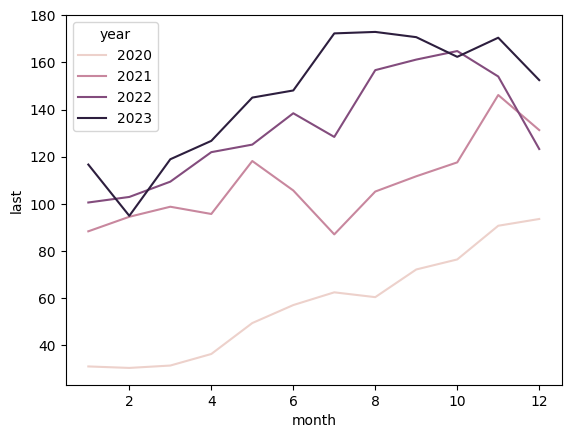

In [33]:
sns.lineplot(data=merged_df, x="month", y="last", hue="year", errorbar=None)